In [1]:
import numpy as np
import tensorflow as tf
import strawberryfields as sf
from numba import njit

In [2]:
sf.__version__

'0.15.1'

In [3]:
def test_sf(cutoff_dim):
    eng = sf.Engine('fock', backend_options={'cutoff_dim':cutoff_dim})

    gamma1 = np.random.normal(scale=0.01) + 1j*np.random.normal(scale=0.01)
    phi1 = np.random.normal(scale=0.01)
    zeta1 = np.random.normal(scale=0.01) + 1j*np.random.normal(scale=0.01)

    
    prog = sf.Program(1)
    gamma1r = np.abs(gamma1)
    gamma1phi = np.angle(gamma1)

    with prog.context as mode:
        sf.ops.Dgate(gamma1r,phi=gamma1phi) | mode[0]
        sf.ops.Rgate(phi1) | mode[0]
        sf.ops.Sgate(zeta1) | mode[0]
    state_out = eng.run(prog).state.ket()
    
    return state_out

In [4]:
import numpy as np
from numba import jit

@njit  # (nb.types.Tuple((nb.complex128, nb.complex128[:], nb.complex128[:,:]))(nb.complex128, nb.float64, nb.complex128))
def C_mu_Sigma(gamma: np.complex, phi: np.float, z: np.complex) -> tuple:
    """
    Utility function to construct:
    1. C constant
    2. Mu vector
    3. Sigma matrix
    Arguments:
        gamma (complex): displacement parameter
        phi (float): phase rotation parameter
        z (complex): squeezing parameter
        dtype (numpy type): unused for now
    Returns:
        C (complex), mu (complex array[2]), Sigma (complex array[2,2])
    """
#     z = convert_scalar(z)
#     phi = convert_scalar(phi)
#     gamma = convert_scalar(gamma)
    r = np.abs(z)
    delta = np.angle(z)
    exp2phidelta = np.exp(1j * (2 * phi + delta))
    eiphi = np.exp(1j * phi)
    tanhr = np.tanh(r)
    coshr = np.cosh(r)
    cgamma = np.conj(gamma)

    C = np.exp(-0.5 * np.abs(gamma) ** 2 - 0.5 * cgamma ** 2 * exp2phidelta * tanhr) / np.sqrt(coshr)
    mu = np.array([cgamma * exp2phidelta * tanhr + gamma, -cgamma * eiphi / coshr,])
    Sigma = np.array([[exp2phidelta * tanhr, -eiphi / coshr], [-eiphi / coshr, -np.exp(-1j * delta) * tanhr],])

    return C, mu, Sigma


@njit
def R_matrix(gamma: np.complex, phi: np.float, z: np.complex, cutoff: int, old_state: np.array) -> np.array:
    """
    Directly constructs the transformed state recursively and exactly.

    Arguments:
        gamma (complex): displacement parameter
        phi (float): phase rotation parameter
        z (complex): squeezing parameter
        old_state (complex array[D]): State to be transformed

    Returns:
        R (complex array[D,D]): the matrix whose 1st column is the transformed state
    """

    dtype = old_state.dtype
    C, mu, Sigma = C_mu_Sigma(gamma, phi, z)

    sqrt = np.sqrt(np.arange(cutoff, dtype=dtype))

    R = np.zeros((cutoff, cutoff), dtype=dtype)
    G0 = np.zeros(cutoff, dtype=dtype)

    # first row of Transformation matrix
    G0[0] = C
    for n in range(1, cutoff):
        G0[n] = mu[1] / sqrt[n] * G0[n - 1] - Sigma[1, 1] * sqrt[n - 1] / sqrt[n] * G0[n - 2]

    # first row of R matrix
    for n in range(cutoff):
        R[0, n] = np.dot(G0[: cutoff - n], old_state)
        old_state = old_state[1:] * sqrt[1 : cutoff - n]

    # rest of R matrix
    for m in range(1, cutoff):
        for n in range(cutoff - m):
            R[m, n] = (
                mu[0] / sqrt[m] * R[m - 1, n]
                - Sigma[0, 0] * sqrt[m - 1] / sqrt[m] * R[m - 2, n]
                - Sigma[0, 1] / sqrt[m] * R[m - 1, n + 1]
            )

    return R

In [5]:
def test_singlemode(cutoff_dim):
    gamma1 = np.random.normal(scale=0.01) + 1j*np.random.normal(scale=0.01)
    phi1 = np.random.normal(scale=0.01)
    zeta1 = np.random.normal(scale=0.01) + 1j*np.random.normal(scale=0.01)

    Psi = np.zeros(cutoff_dim,dtype=np.complex128)
    Psi[0] = 1  #vaccum
    state_out = R_matrix(gamma1,phi1, zeta1,cutoff_dim, Psi)[:,0]
    return state_out

In [6]:
x = [5,10,15,20,25,30,35,40]

In [7]:
time_list_sf = []
for cutoff_dim in x:
    t = %timeit -o test_sf(cutoff_dim)
    time_list_sf.append(t.average)

1.97 ms ± 879 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)
1.72 ms ± 717 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
1.22 ms ± 526 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
1.29 ms ± 360 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
1e+03 µs ± 292 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
822 µs ± 88.5 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
1.05 ms ± 181 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
1.12 ms ± 172 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [8]:
time_list_2mode = []
for cutoff_dim in x:
    t = %timeit -o test_singlemode(cutoff_dim)
    time_list_2mode.append(t.average)

35.8 µs ± 22.7 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)
28 µs ± 2.3 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)
46 µs ± 14.9 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)
34.5 µs ± 2.36 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)
42.6 µs ± 6.46 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)
41.5 µs ± 279 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)
60.1 µs ± 16.7 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)
53.5 µs ± 1.65 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


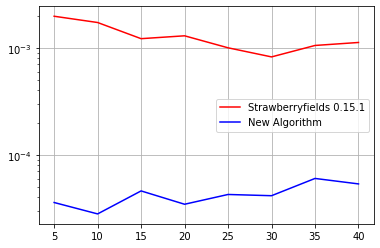

In [9]:
from matplotlib import pyplot as plt
plt1 = plt.plot(x,time_list_sf,'r');
plt2 = plt.plot(x,time_list_2mode,'b');
# plt3 = plt.plot(x,time_list_2mode2,'y');
plt.yscale('log')
plt.grid(True)
plt.legend((plt1[0],plt2[0]),("Strawberryfields 0.15.1","New Algorithm"))

In [10]:
time_list_sf

[0.0019718145818582605,
 0.0017229750187003187,
 0.0012169246588434493,
 0.0012943605382627408,
 0.0009997798327157008,
 0.0008220582175833572,
 0.0010515300780035823,
 0.0011213417229675021]

In [11]:
time_list_2mode

[3.583572937973908e-05,
 2.803339737334422e-05,
 4.59833134431392e-05,
 3.451277251255565e-05,
 4.259514887151974e-05,
 4.1481226574563024e-05,
 6.013486231677234e-05,
 5.3461466057758245e-05]